# Notebook 1: The "Why" — Understanding Transformers and the Physics Bottleneck
**Based on the paper:**\
Transolver: A Fast Transformer Solver for PDEs on General Geometries
(Wu et al., 2024, arXiv:2402.02366v2)

Welcome to this tutorial series! 👋

In this series, we’ll go from Transformer theory to Transolver, a new approach for large-scale physics simulations. The goal is to build a complete, end-to-end understanding, from the fundamental concepts to a real, working training pipeline.

This series is broken into three notebooks, each building on the last:

* **Notebook 1 (The "Why"):** We will start by exploring the core "attention" mechanism of a standard Transformer. We will then discover its critical flaw: the "quadratic complexity" ($O(N^2)$). You will see why this "quadratic bottleneck" makes it "computationally prohibited" for the "large-scale meshes" used in real-world physics.

* **Notebook 2 (The "How"):** We'll build a `NumPy` "blueprint" of the Transolver solution: **Physics-Attention**. We will implement the 4-step mathematical process (Slice, Aggregate, Attend, Deslice) that breaks this bottleneck. This notebook will explain the *internal mechanics* of how Transolver learns "intrinsic physical states" by grouping mesh points into "learnable slices" and performing attention on a few "physics-aware tokens".

* **Notebook 3 (The "Factory"):** We'll move from blueprint to reality. We will use the official **Physics-NEMO** library and the associated scripts (`datapipe.py`, `preprocess.py`, etc.) to build a complete, professional-grade training pipeline. We will preprocess your 508 VTP/STL files into the Zarr format, calculate the necessary normalization statistics, and run a real (abbreviated) training loop for a few epochs to see it all work.

---

This first notebook builds the foundation, focusing on two key questions:

1.  What is the core idea behind the Transformer (the “attention” mechanism)?
2.  Why does this brilliant idea fail when directly applied to large-scale physics and engineering problems?

By the end, you’ll understand the computational bottleneck that Transolver was designed to solve, and how this relates to mesh-based simulations like those in aerodynamics or crash mechanics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
import os
# --- For slicing viz ---
from sklearn.cluster import KMeans
# --------------------------------------------------

# Setup for PyVista plotting in a headless environment
pv.start_xvfb()
os.environ["XDG_RUNTIME_DIR"] = "/tmp"

/usr/local/lib/python3.12/dist-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


# Part 1: What is a Transformer?

The core idea of a Transformer is "self-attention."

In simple terms: every element (e.g., a word in a sentence
or a node in a mesh) looks at every other element to
calculate a "score" of how relevant they are to each other.
It then updates itself by taking a weighted average of all
other elements, based on those scores.
This "all-to-all" communication is what makes it so powerful,
but also so computationally expensive.

This code block below builds a "toy" self-attention mechanism from scratch using only NumPy. This is the core engine inside every Transformer model (like GPT, BERT, and Transolver).

### The Goal: "All-to-All" Communication

The goal of self-attention is to update every item in a sequence (e.g., every word in a sentence, or every node in a mesh) by letting it "look at" and "gather information from" every other item in the sequence.

To do this, the model learns three transformations for each input item $X$:
1.  **Query (Q):** "What am I looking for?"
2.  **Key (K):** "What information do I have?"
3.  **Value (V):** "What information will I give, if someone pays attention to me?"

### The 4-Step Process in the Code:

1.  **Project:** We start with our input `X` (5 items, 4 features each) and "project" it into `Q`, `K`, and `V` using three (normally learned) weight matrices `W_q`, `W_k`, `W_v`.
2.  **Score:** The model calculates a "score" matrix by comparing every **Query** with every **Key** (`scores = Q @ K.T`). This is the **$O(N^2)$** step where every item interacts with every other item. The resulting $(N, N)$ matrix shows the "relevance" of each item to every other item.
3.  **Normalize:** The scores are scaled (for numerical stability) and then run through a `softmax` function. This turns the raw scores into a matrix of **`attention_weights`** (percentages). Each row now sums to 1.0.
4.  **Aggregate:** The final `output` is calculated as a **weighted average**. For each item `i`, its output is the sum of all other items' **Values (V)**, weighted by the **`attention_weights`** we just calculated.

This code block implements this entire process for a tiny sequence of $N=5$ items.


=== Self-Attention Mechanism (Toy Example) ===
Input shape (N=5, d_model=4): (5, 4)
Attention matrix shape (N, N): (5, 5)
Output shape: (5, 4)


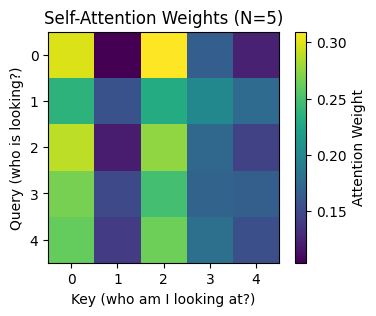

In [2]:
print("=== Self-Attention Mechanism (Toy Example) ===")

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

np.random.seed(42)
N = 5       # sequence length (e.g., 5 words or 5 mesh nodes)
d_model = 4 # embedding dimension
d_k = 3     # dimension for Q and K

X = np.random.rand(N, d_model)  # toy input

# Q, K, V are just "projections" of the input data
W_q = np.random.rand(d_model, d_k)
W_k = np.random.rand(d_model, d_k)
W_v = np.random.rand(d_model, d_model)

Q = X @ W_q
K = X @ W_k
V = X @ W_v

# The O(N^2) bottleneck is here:
scores = Q @ K.T  # Shape (N, N)
# ---

scaled_scores = scores / np.sqrt(d_k)
attention_weights = softmax(scaled_scores)
output = attention_weights @ V

print(f"Input shape (N={N}, d_model={d_model}):", X.shape)
print(f"Attention matrix shape (N, N):", scores.shape)
print("Output shape:", output.shape)

plt.figure(figsize=(4,3))
plt.imshow(attention_weights, cmap="viridis")
plt.title(f"Self-Attention Weights (N={N})")
plt.xlabel("Key (who am I looking at?)")
plt.ylabel("Query (who is looking?)")
plt.colorbar(label="Attention Weight")
plt.show()

### Figure Explanation: The Attention Weight Matrix

This 5x5 heatmap is a visualization of the `attention_weights` matrix, which is the "brain" of the self-attention mechanism.

* **Y-axis ("Query"):** This represents the item that is "looking" or "gathering information." For example, row 2 is "Item 2."
* **X-axis ("Key"):** This represents the item that is "being looked at." For example, column 4 is "Item 4."
* **Color (Brightness):** The color at `(row_i, col_j)` shows the **attention weight** (a value from 0.0 to 1.0).
    * **Bright Yellow:** High weight (e.g., ~0.8). This means the "Query" item (`i`) is paying a *lot* of attention to the "Key" item (`j`).
    * **Dark Purple:** Low weight (e.g., ~0.1). This means the "Query" item (`i`) is mostly *ignoring* the "Key" item (`j`).

**How to Read It:**
Look at a single row (e.g., Row 0). The colors in that row show how "Item 0" distributes its attention. Because we used `softmax`, all the weights (colors) in that single row add up to 1.0.

**The $O(N^2)$ Bottleneck:**
This visualization *is* the $O(N^2)$ bottleneck. We can easily compute and plot this 5x5 matrix. But for a real physics problem with $N=400,000$, we would need to compute and store a 400,000 x 400,000 matrix, which (as we'll see next) is computationally impossible.

# Part 2: Why Standard Transformers Fail for Physics

In [3]:
N_physics = 400_000  # typical number of surface nodes
num_ops = N_physics**2
print(f"\nFor N = {N_physics:,} nodes, we need N^2 interactions.")
print(f"N^2 = {num_ops/1e9:.1f} BILLION interactions.")
print("This is computationally prohibited to fit in GPU memory.")


For N = 400,000 nodes, we need N^2 interactions.
N^2 = 160.0 BILLION interactions.
This is computationally prohibited to fit in GPU memory.



The O(N^2) computation in `scores = Q @ K.T` is the problem.
For N=5, N^2 = 25 interactions. This is trivial.
But for a real physics problem...

**This leads to a "quadratic bottleneck" with two main parts:**

### 1. The Computation Bottleneck

That number—160.0 billion—is just for *one* attention head in *one* layer. A real model might have 12 layers, each with 8 heads. The computational cost is astronomical.

### 2. The Memory Bottleneck (The Real Killer)

Even if we had infinite time, this is a "computationally prohibited" problem because of **memory**.

That $(N, N)$ attention matrix has to be *stored* in the GPU's memory to be used.

* **Matrix size:** $400,000 \times 400,000 = 1.6 \times 10^{11}$ entries.
* **Memory per entry:** A standard 32-bit float takes 4 bytes.
* **Total Memory:** $(1.6 \times 10^{11}) \times 4 \text{ bytes} \approx$ **640 Gigabytes of VRAM!**



This is for **one matrix**. A high-end 80GB GPU (like an NVIDIA A100 or H100) simply cannot store it. The model can't even be built, let alone trained.

### The Core Problem: Wasted Effort

This massive $O(N^2)$ calculation isn't just infeasible, it's also incredibly **wasteful**. The model is forced to "efficiently capture physical correlations" from this "discretized domain."

Let's break that down:

* **"Discretized Domain":** This is your 400,000-node mesh. It's just a "superficial" list of (x,y,z) points.
* **"Physical Correlations":** This is the *actual physics*. For example: The high pressure at the front bumper *causes* the flow to accelerate over the roof (creating low pressure). The flow separation at the rear *causes* the turbulent wake.
* **The Transformer's Mistake:** A standard Transformer *tries* to learn these physical laws by calculating the interaction score between *every single point and every other point*. It wastes billions of calculations finding the "correlation" between a point on the left headlight and a point on the right-rear tire, an interaction that is physically meaningless.

This is the key challenge: How do you "transform" a Transformer into a practical PDE solver? You must find a way to *efficiently* capture these important physical correlations without the crippling $O(N^2)$ cost.


## Part 2a: The Core Problem (Paper Clarification)
### Clarification: The Core Problem in PDE Solvers

The core challenge in applying Transformers to PDEs is:

> "Thus, how to efficiently capture physical correlations
> underlying the discretized domain is the key to 'transform'
> Transformers into practical PDE solvers."

Let's break this down:

1.  **"Discretized domain":** This is your 400,000-node mesh. It's a "superficial and unwieldy" set of points. A standard Transformer, when "directly applying attention to massive mesh points," gets overwhelmed and struggles to find meaningful relationships.

2.  **"Physical correlations":** This is the *actual physics* happening. PDEs involve "extremely complex spatiotemporal interactions." For example:
    * The high pressure at the front bumper *causes* the flow to accelerate over the roof (creating low pressure).
    * The flow separation at the rear windshield *causes* the turbulent wake (drag) behind the car.
    A standard Transformer *tries* to learn these "high-order and intricate correlations" by just looking at all 400,000 individual points and their $O(N^2)$ interactions.

3.  **"How to efficiently capture...":** The $O(N^2)$ method is "computationally prohibited." It's not *efficient*. The "key" is to find a new, *smarter* way to capture these physical laws.

---

### Transolver's Solution: From Points to Physical States

Instead of looking at 400,000 points, Transolver is based on a more foundational idea: **"learning intrinsic physical states"** hidden in the mesh.

Its **Physics-Attention** mechanism does this:
* It **"adaptively splits"** the discretized domain into a series of **"learnable slices."**
* Critically, "mesh points under similar physical states will be ascribed to the same slice."
* It then **"encodes"** each slice into a single **"physics-aware token."**
* Finally, it computes efficient $O(M^2)$ attention between these few **tokens** (e.g., 64 tokens instead of 400,000 points).

This is far more powerful than just spatial clustering. For example, the model can learn to group the **windshield, license plate, and headlights** into the *same slice*. Why? Because even though they are spatially separate, they all share the same physical state of being in the "front area" of the car, which is highly related to the drag force.

This is the solution: it's far more efficient ($O(M^2)$ vs $O(N^2)$) and also *smarter* because it operates on learned physical concepts, not just raw, unwieldy points.
"""))

---
# Part 3: Locality in Physics — Why Global Attention is Wasteful
In fluid mechanics, most interactions are local:
 pressure at the front bumper correlates strongly *only*
with nearby regions, not with the far wake.

Standard attention wastes computation by calculating
high-precision scores between two points that are
meters apart and have no physical relationship.

We'll demonstrate this by sampling pressure data from **ONE Ahmed Body simulation**

In [4]:
# Define the directory where the simulation data is stored.
data_dir = "/workspace/transformer/dli/ahmed-body"

# Use os.listdir() to find all files in the directory.
# We filter this list to include *only* files that end with ".vtp".
# ".vtp" is a "VTK PolyData" file, a standard format for 3D geometry/mesh data.
# We sort the list to ensure we get a consistent file (e.g., "case_0.vtp") first.
vtp_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".vtp")])

print(f"Found {len(vtp_files)} VTP surface files.")

# --- NOTE: We use ONLY ONE FILE ---
# To demonstrate the concept of spatial locality, we only need
# to analyze the spatial correlations within a single simulation.
# (This also avoids issues if multiple simulations
# have different geometries).

# Make sure we actually found some files before proceeding.
if not vtp_files:
    raise FileNotFoundError(f"No VTP files found in {data_dir}")

print(f"Loading and sampling file: {vtp_files[0]}")

# Use PyVista (pv.read) to load the first VTP file into memory.
# 'ref_mesh' is now a PyVista object holding the 3D geometry (all the points)
# and all the simulation data associated with those points.
ref_mesh = pv.read(vtp_files[0]) # This is our single source

# We need to make sure the data we care about ("p" for pressure) exists.
# 'ref_mesh.point_data' holds all the data arrays.
# We check if 'p' is a key in this data.
if "p" not in ref_mesh.point_data:
    # If not, raise an error showing all the *available* array names.
    # This is good practice for debugging.
    raise ValueError(f"'p' not found in {vtp_files[0]}. Available arrays: {ref_mesh.array_names}")

# --- Sub-sampling the Mesh ---
# The full mesh might have 400,000+ points. Calculating all-vs-all
# distances for this (which is O(N^2)) is too slow for a demo.
# So, we will randomly sample 5,000 points from the full mesh.
n_sample_points = 5000
n_total_points = ref_mesh.n_points
print(f"Full mesh has {n_total_points:,} points. Sampling {n_sample_points}...")

# np.random.choice is a perfect tool for this.
# 1. We create a list of all possible indices (from 0 to n_total_points).
# 2. We ask it to *choose* 'n_sample_points' of them.
# 3. 'replace=False' means we pick 5,000 *unique* points, which is what we want.
ids = np.random.choice(n_total_points, min(n_sample_points, n_total_points), replace=False)

# --- Extract the Data ---
# 'ids' is now our array of 5,000 random indices.
# We use these indices to "slice" the main data arrays.

# Get the (x, y, z) coordinates for our 5,000 sample points.
coords_sample = ref_mesh.points[ids]

# Get the corresponding pressure value 'p' for *only* those 5,000 points.
p_sample = ref_mesh.point_data["p"][ids]

print(f"Total sampled surface points: {coords_sample.shape[0]:,}")
print("Sampled coordinates shape:", coords_sample.shape)
print("Sampled pressure shape:", p_sample.shape)


Found 50 VTP surface files.
Loading and sampling file: /workspace/transformer/dli/ahmed-body/case100.vtp
Full mesh has 76,975 points. Sampling 5000...
Total sampled surface points: 5,000
Sampled coordinates shape: (5000, 3)
Sampled pressure shape: (5000,)


## Part 3a: Visualize One Example

/usr/local/lib/python3.12/dist-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


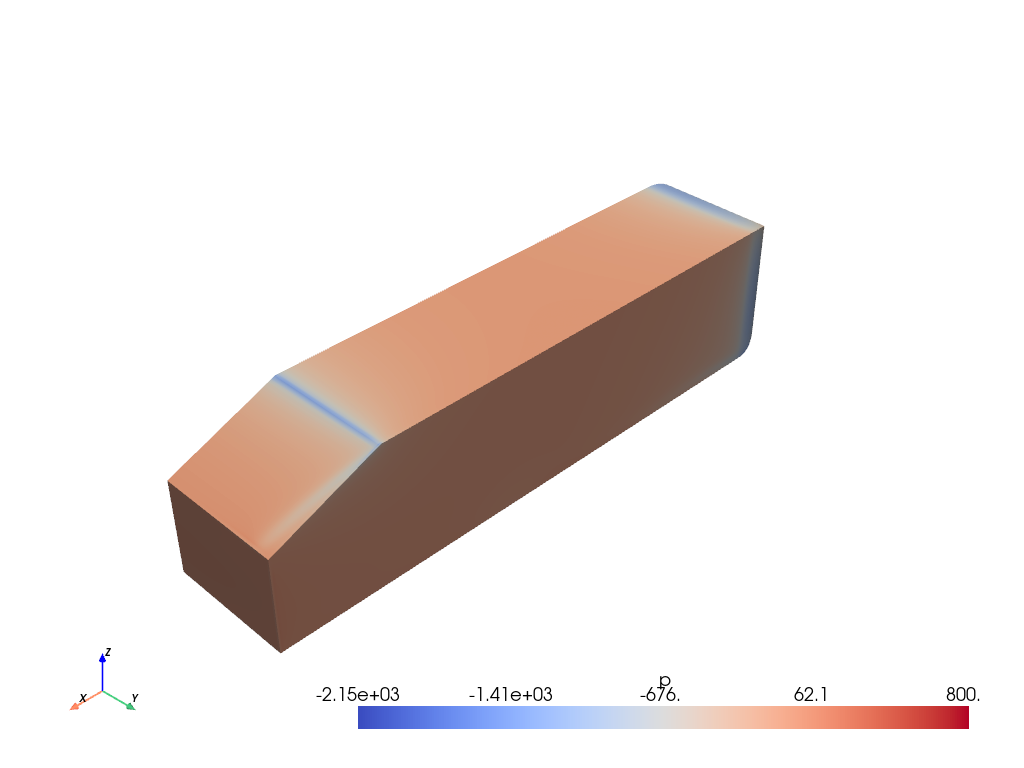

In [5]:
# Use the 'ref_mesh' we already loaded
plotter = pv.Plotter()
plotter.add_mesh(ref_mesh, scalars="p", cmap="coolwarm", show_scalar_bar=True)
plotter.add_axes()
plotter.show(title="Ahmed Body Surface Pressure (Case 0)")

## Part 3b: Empirical Locality — Correlation vs. Spatial Distance
### Explanation: What Are We Doing?

In this section, we will **quantify** the idea of spatial locality. We have a hypothesis:

> "In a physics simulation, two points that are **spatiaially close** to each other will have **similar pressure** values. As the distance between the two points increases, their pressure similarity will decrease."

To prove this, we need to compare two quantities for *every possible pair* of points in our 5,000-point sample:
1.  **Spatial Distance:** How far apart are point `i` and point `j` in meters?
2.  **Pressure Similarity:** How similar is the pressure at point `i` to the pressure at point `j`?

### Step 1: Calculating Pairwise Distances

First, we need the spatial distance. We will use `scipy.spatial.distance.pdist` (pairwise distance) on our `coords_sample` (shape 5000, 3). This is much faster than writing a manual double `for` loop.

This function will compute the distance between point 1 and point 2, point 1 and point 3, ..., point 4999 and point 5000. The result is a flat list of all $N \times (N-1) / 2$ unique distances. `squareform` then turns this flat list into a full $(N, N)$ matrix `D` where `D[i, j]` is the distance between point `i` and point `j`.

### Step 2: Calculating Pressure Similarity

Next, we need to calculate the pressure similarity. We will use a simple "approximate" method for this single-file snapshot.

1.  **Normalize Pressure:** We first normalize the pressure `p_sample` (by subtracting the mean and dividing by the standard deviation). This gives us `p_norm`, where positive values are "higher-than-average" pressure and negative values are "lower-than-average."
2.  **Outer Product:** We then compute an "outer product" (`p_vec @ p_vec.T`). This creates an $(N, N)$ similarity matrix `C_approx`.
    * If `p_norm[i]` and `p_norm[j]` are *both* positive (both high pressure), `C_approx[i, j]` will be **positive** (high similarity).
    * If `p_norm[i]` and `p_norm[j]` are *both* negative (both low pressure), `C_approx[i, j]` will also be **positive** (high similarity).
    * If one is positive and one is negative, `C_approx[i, j]` will be **negative** (low similarity).

### Step 3: Binning and Plotting

We now have two $(N, N)$ matrices: `D` (Distances) and `C_approx` (Similarities). We can't plot $5000^2$ individual dots.

Instead, we **bin** the data to see the trend:
1.  Create 50 distance "bins" (e.g., 0.0-0.1m, 0.1-0.2m, ...).
2.  For each bin, find *all* point pairs `(i, j)` whose distance `D[i, j]` falls into that bin.
3.  Calculate the *average similarity* `C_approx[i, j]` for all those pairs.
4.  Finally, plot the **(Average Similarity)** vs. **(Distance Bin)**.

This will show us the clear trend we're looking for. We only use the upper triangle of the matrices (`np.triu_indices_from`) to avoid double-counting pairs (since the distance from `i` to `j` is the same as `j` to `i`).

Calculating pairwise distances...
Calculating pressure similarity...
Binning data for plotting...


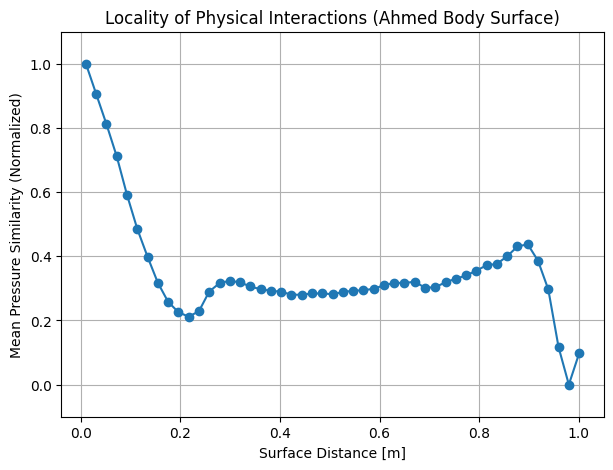

In [6]:
print("Calculating pairwise distances...")
# Pairwise spatial distances between our sample points
D = squareform(pdist(coords_sample))  # distances

print("Calculating pressure similarity...")
# --- Approximate similarity (for a single snapshot) ---
# Normalize pressure
p_norm = (p_sample - np.mean(p_sample)) / np.std(p_sample)
p_vec = p_norm.reshape(-1,1)
# C[i, j] is high if p[i] and p[j] are both high (or both low)
C_approx = (p_vec @ p_vec.T)

# Use only upper triangle to avoid redundancy
triu = np.triu_indices_from(D, k=1)
distances = D[triu]
similarity = C_approx[triu]

print("Binning data for plotting...")
# Bin by distance to compute mean similarity
bins = np.linspace(0, np.percentile(distances, 95), 50)
bin_centers = 0.5*(bins[1:] + bins[:-1])
mean_similarity = []

for i in range(len(bins)-1):
    mask = (distances >= bins[i]) & (distances < bins[i+1])
    mean_similarity.append(similarity[mask].mean() if np.any(mask) else np.nan)

# --- Normalize the final plot to be between [~0, 1] ---
mean_similarity = np.array(mean_similarity)
mean_similarity_norm = (mean_similarity - np.nanmin(mean_similarity)) / (np.nanmax(mean_similarity) - np.nanmin(mean_similarity))
# ---------------------------------------------------------

plt.figure(figsize=(7,5))
plt.plot(bin_centers, mean_similarity_norm, marker='o', color='tab:blue') # Plot normalized
plt.xlabel("Surface Distance [m]")
plt.ylabel("Mean Pressure Similarity (Normalized)")
plt.title("Locality of Physical Interactions (Ahmed Body Surface)")
plt.grid(True)
plt.ylim(-0.1, 1.1)
plt.show()


### Plot Explanation
The curve on this plot is our **proof**.

* At **zero distance** (left side), the similarity is **high (near 1.0)**. This is logical: a point is perfectly correlated with itself and its immediate neighbors.
* As the **distance increases** (moving right), the similarity **decays rapidly**.
* You may also see a **long plateau** after the initial drop. This indicates that while physics is *mostly* local (the sharp drop), there is a *low-level, long-range correlation* across the entire body.

This plot visually confirms our hypothesis: **physics is mostly local, but not strictly zero globally.** This is the exact property that Transolver is designed to exploit.

---
# Part 4: The Transolver Solution: Physics-Attention

Instead of operating on "massive individual points," the model is based on a more foundational idea: **"learning intrinsic physical states hidden behind discretized geometries."**

The core invention to achieve this is **Physics-Attention**. This mechanism is a 4-step process that avoids the $O(N^2)$ bottleneck:

1.  **Slice:** The model first **splits** the $N$ mesh points into $M$ "learnable slices" (where $M \ll N$, e.g., 64 slices for 400,000 points).
2.  **Aggregate (Encode):** It then **encodes** each of the $M$ slices into a single "physics-aware token." This token represents the general state of all the points within that slice. This is how the model learns to **group** points with "similar physical states" together.
3.  **Attend:** The model performs an efficient $O(M^2)$ attention calculation *only* on these $M$ tokens. This is where the different physical regions of the simulation (e.g., the front bumper, the roof, the wake) "talk" to each other.
4.  **Deslice (Broadcast):** Finally, the updated information from the $M$ tokens is **broadcasted** (mapped back) to the $N$ original points, giving each point its updated value based on these global physical interactions.

This process essentially maps the complex "Discretized Domain" ($N$ points) to a much simpler "Physics Domain" ($M$ tokens) where the expensive computation happens.
"""))

### Display Figure 2 from the paper
Conceptual Figure:** (a) The Discretized Domain ($N$ points) is mapped to (b) The Physics Domain, which consists of $M$ Slices. These slices are aggregated into $M$ Tokens, which is where attention is computed.



### Why Slices are Smarter than Simple Patches

It's tempting to think of these "slices" as just simple spatial patches, like dividing an image into a grid. The k-means visualization we will do next is just such a simple *spatial* proxy.

However, the actual learned slices are much more powerful. Because they are **learned** from the data (not fixed), they can group points that share a similar *physical role*, even if they are **spatially distant**.

For example, the model can learn to ascribe the **windshield, license plate, and headlight** of the car into the *same slice*. Why? Because even though they are far apart, they are all part of the **"front area"** during driving and are all highly related to the calculation of drag force. This is something a simple spatial patch could never do.


## Part 4a: Visualizing a *Proxy* for Slicing (K-Means)
As a simple proxy, we can use k-means clustering on the
point coordinates to simulate a *spatial* partitioning.
Keep in mind the real slices are *learned* from physics
features and are far more sophisticated.


Visualizing Transolver 'Slicing' concept (KMeans Proxy)...


/usr/local/lib/python3.12/dist-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


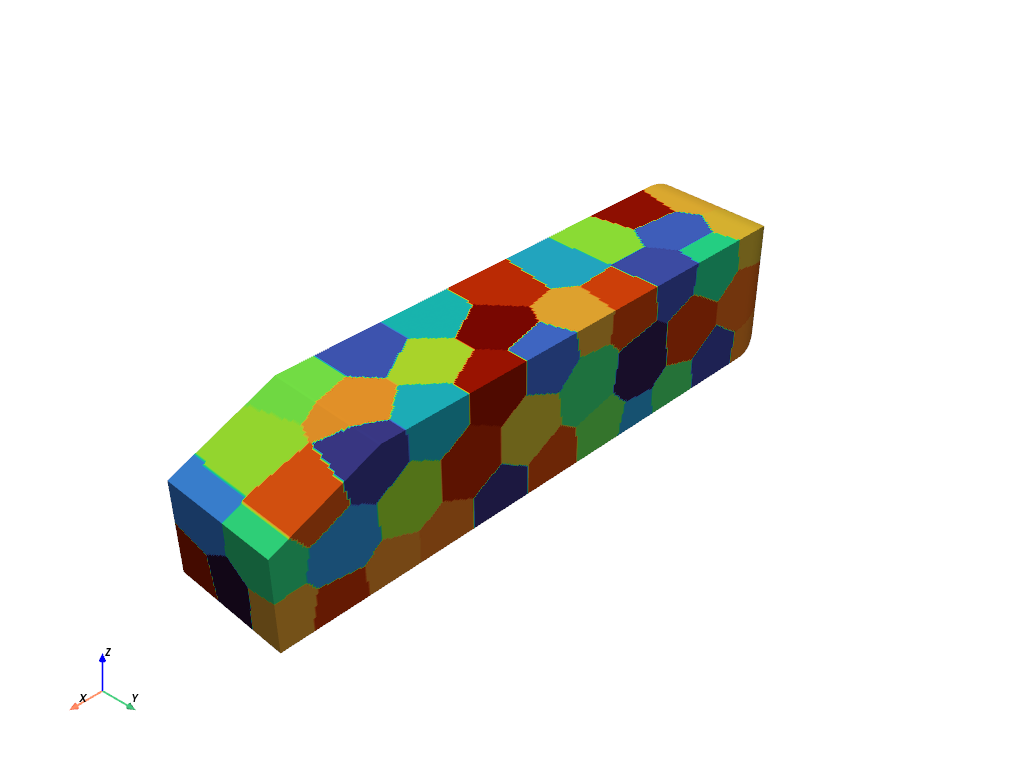

Visualized mesh partitioned into 64 simple spatial slices.


In [7]:

print("\nVisualizing Transolver 'Slicing' concept (KMeans Proxy)...")
M = 64  # Number of slices, as mentioned in the paper [cite: 225]

# We use the full reference mesh for visualization
mesh_for_slicing = ref_mesh.copy()
points = mesh_for_slicing.points

# Use KMeans to cluster the points into M slices
kmeans = KMeans(n_clusters=M, random_state=42, n_init=10)
clusters = kmeans.fit_predict(points)

# Add the cluster IDs to the mesh as point data
mesh_for_slicing.point_data["slice_id"] = clusters

# Plot the mesh, colored by the new 'slice_id'
plotter = pv.Plotter()
plotter.add_mesh(
    mesh_for_slicing,
    scalars="slice_id",
    cmap="turbo",  # Good for discrete categories
    show_scalar_bar=False,
    categories=True # Treat scalars as discrete categories
)
plotter.add_axes()
plotter.show(title=f"Ahmed Body Partitioned into M={M} 'Slices' (KMeans Proxy)")

print(f"Visualized mesh partitioned into {M} simple spatial slices.")

## Part 4b: What Learned Slices *Actually* Look Like
The k-means plot above shows a simple **spatial clustering**. It's a "dumb" proxy that only knows about (x, y, z) coordinates. It's physically naive—it doesn't know *why* one part of the mesh is different from another, only *where* it is.

In contrast, the **actual learned slices** in a trained model are far more complex and physically intelligent.

Because the slices are learned from the *physical features* (like pressure, velocity, etc.), not just coordinates, they learn to group points that share a common **physical state** or **role in the simulation**.

This means they learn to automatically discover and isolate complex physical phenomena. For example:
* On an **airfoil**, the slices learn to separate the points involved in the **shock wave** from the points in the **wake flow**.
* In a **Darcy flow** (fluid in a porous medium), they learn to identify different regions of **fluid-structure interaction**.
* On the **Ahmed body**, they learn to group all the high-pressure "front-facing" points together and separate them from the low-pressure "roof" points.

This is the key difference: k-means creates simple geometric patches, while Physics-Attention *discovers* and *learns* the underlying physical phenomena of the simulation.


### Display Figure 1 from the paper

**Conceptual Figure:** Examples of *real, learned slices* for different physics problems. A brighter color means the mesh point "is more ascribed to the corresponding slice." Notice how the slices are not simple squares but follow the complex patterns of the physics itself.


### Part 4c: The Payoff: Linear Complexity
This four-step "slice-aggregate-attend-broadcast" process is the key to Transolver's efficiency. It's visualized as a full layer below.



[Image of the Transolver layer architecture diagram]

 **Conceptual Figure:** The full Transolver layer. It replaces standard $O(N^2)$ attention with the Physics-Attention block, which performs (1) Slice, (2) Aggregate, (3) Attention for Tokens ($M \times M$), and (4) Deslice/Broadcast.

The computational cost changes dramatically.

---

### Traditional Transformer:
$$
\text{Cost} \sim O(N^2)
$$
As we saw in Part 2, this is the **quadratic bottleneck**. If you double the number of mesh points ($N$), the cost and memory *quadruple*. This is what makes it "computationally prohibited."

---

### Transolver:
$$
\text{Cost} \sim O(NMC + M^2C)
$$
(Where $N$=mesh points, $M$=slices, $C$=channels)

Let's break down this new cost:

1.  **The $O(NMC)$ term:** This is the "linear" part. Where does it come from?
    * **Step 1 (Slicing):** `(N, C) @ (C, M)`. Cost is proportional to $N \times M \times C$.
    * **Step 2 (Aggregation):** `(M, N) @ (N, C)`. Cost is proportional to $N \times M \times C$.
    * **Step 4 (Deslicing):** `(N, M) @ (M, C)`. Cost is proportional to $N \times M \times C$.
    Notice that $N$ appears only once in each term. This means if you double the number of mesh points ($N$), the cost of these steps just **doubles**. This is **linear scaling**.

2.  **The $O(M^2C)$ term:** This is the "tiny, constant" part.
    * **Step 3 (Token Attention):** `(M, C) @ (C, M)`. Cost is proportional to $M \times M \times C$.
    * This is the core attention calculation! Crucially, its cost **does not depend on $N$ at all!**

**Why this is called $O(N)$ (Linear):**

In a model, $M$ and $C$ are small, fixed hyperparameters (like $M=64, C=128$). Because they are *constants*, the entire $O(M^2C)$ term is just one small, constant cost. The $O(NMC)$ term simplifies to $O(N \times \text{constant})$, which is just $O(N)$.

This means the total cost of the layer scales **linearly** with the number of mesh points, not quadratically.

---

### Example: The Bottleneck Solved

Let's compare the *core attention cost* ($N^2$ vs $M^2$) using our typical numbers.

| Parameter | Meaning | Traditional Transformer | Transolver |
|------------|----------|---------------|---------------|
| $N$ | Number of surface/mesh nodes | 400,000 | 400,000 |
| $M$ | Learned physics slices | (Not used) | 64 |
| **Attention Cost** | **$N^2$ vs $M^2$** | $400,000^2 \approx$ **160 Billion** | $64^2 = $ **4,096** |

This is the "payoff." Transolver replaces an **impossible** 160-billion-interaction problem with a **trivial** 4,096-interaction one.

This transforms the problem from **impossible** to **highly efficient**.
"""))


# Summary
### Key Takeaways

1.  **Transformers** rely on global all-to-all attention. This has a **quadratic $O(N^2)$ complexity**, meaning if you double the mesh points, the computational cost *quadruples*. This is "computationally prohibited" for large physics meshes, not just because it's slow, but because the massive $O(N^2)$ attention matrix (e.g., 400,000 x 400,000) is **too large to fit into any modern GPU's memory**.

2.  **Physics systems** (like CFD) exhibit strong **spatial locality**. We confirmed this with our plot: a point's pressure is highly correlated with its immediate neighbors, and this correlation drops off quickly with distance. This means the $O(N^2)$ attention is extremely **wasteful**, spending billions of calculations on interactions between distant points that have no physical relationship (like the front bumper and the rear wake).

3.  **Transolver** introduces **Physics-Attention**. Instead of attending to $N$ individual, "unwieldy" points, the model learns to group them into $M$ **"learnable slices"** (where $M \ll N$, e.g., $M=64$). This is a "divide and conquer" strategy. The model's goal is to learn to group points based on their **"intrinsic physical states,"** not just their location.

4.  **Slices are Smart, Not Just Spatial:** These slices are not just simple, fixed patches (like a grid). They are *learned* during training. This means they can intelligently group **spatially distant** points that share a common physical role. For example, the model can learn to put the **windshield, headlights, and license plate** into the *same slice* because they all belong to the "front-facing, high-pressure" physical state of the car.

5.  **Efficiency and Linear Scaling:** The model computes attention on $M$ "physics-aware tokens" (one aggregated token representing each slice). This reduces the main computational bottleneck from $O(N^2)$ to a tiny, constant $O(M^2)$. The other steps (like slicing and deslicing) scale *linearly* with the number of points ($O(N)$). The final result is a model whose cost scales as $O(N)$, not $O(N^2)$, finally enabling deep learning to be applied to large-scale, real-world physics problems.

---
Next Notebook:
> Notebook 2 — *From Local Physics to Transolver Implementation*